In [13]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import scipy

In [3]:
def plot_image(img):
    img = cv.cvtColor(img, cv.COLOR_GRAY2RGB)

    plt.imshow(img)
    plt.axis('off')
    plt.show()

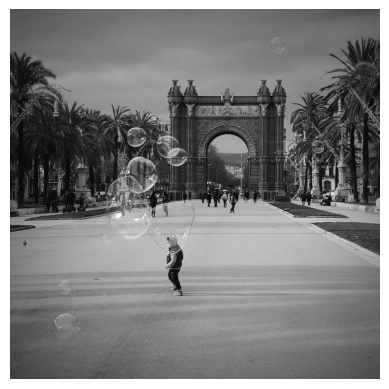

[[79 79 79 ... 72 72 72]
 [79 79 79 ... 72 72 72]
 [79 79 79 ... 72 72 72]
 ...
 [63 63 63 ... 77 76 75]
 [60 60 61 ... 70 71 71]
 [55 57 58 ... 71 72 73]]


In [14]:
img = cv.imread('new_pic.jpg')
img = cv.cvtColor(img, cv.COLOR_RGB2GRAY)
plot_image(img)


In [20]:
img_out_pulse = cv.imread('pulse.png')
img_out_pulse = cv.cvtColor(img_out_pulse, cv.COLOR_BGR2GRAY)

img_out_multip = cv.imread('multip.png')
img_out_multip = cv.cvtColor(img_out_multip, cv.COLOR_BGR2GRAY)

img_out_gauss = cv.imread('gauss.png')
img_out_gauss = cv.cvtColor(img_out_gauss, cv.COLOR_BGR2GRAY)

img_out_quant = cv.imread('quant.png')
img_out_quant = cv.cvtColor(img_out_quant, cv.COLOR_BGR2GRAY)

Начнем с медианной фильтрации

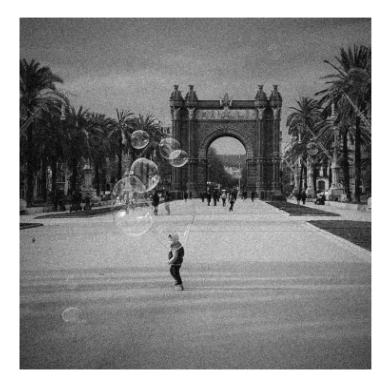

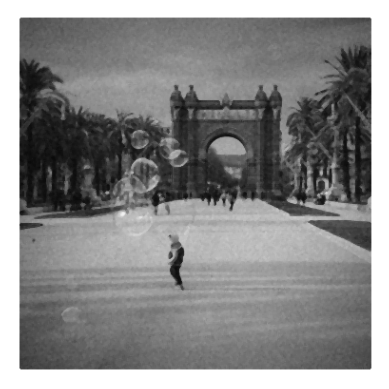

In [24]:
plot_image(img_out_gauss)
out = cv.medianBlur(img_out_gauss,3)
plot_image(out)

Взвешенная медиана и ранговая 

uint8


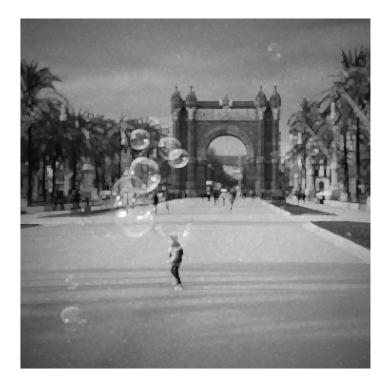

In [41]:
I = np.copy(img_out_quant)
k_size = (3,3)
rank = 8
kernel = np.ones(k_size,dtype = np.float32)
rows, cols = I.shape[0:2]
print(I.dtype)
if I.dtype == np.uint8:
    I_copy = I . astype ( np . float32 ) / 255
else:
    I_copy = I
I_copy = cv.copyMakeBorder(I_copy, int (( k_size [0] - 1) / 2) , int ( k_size [0] / 2) , int (( k_size [1] - 1) / 2) ,
                           int ( k_size [1] / 2) , cv . BORDER_REPLICATE )

I_layers = np.zeros(I.shape + (k_size[0] * k_size[1], ), dtype = np.float32)

if I.ndim == 2:
    for i in range(k_size[0]):
        for j in range(k_size[1]):
            I_layers[:,:, i * k_size[1] + j] = kernel[i,j] *  I_copy[i:i + rows, j:j + cols]
else:
    for i in range(k_size[0]):
        for j in range(k_size[1]):
            I_layers[:,:,:, i * k_size[1] + j] = kernel[i, j] * I_copy[i:i + rows, j:j + cols, :]
I_layers.sort()

if I.ndim == 2:
    I_out = I_layers[:, :, rank]
else:
    I_out = I_layers[:,:,:, rank]

plot_image(I_out)

Винеровская фильтрация 

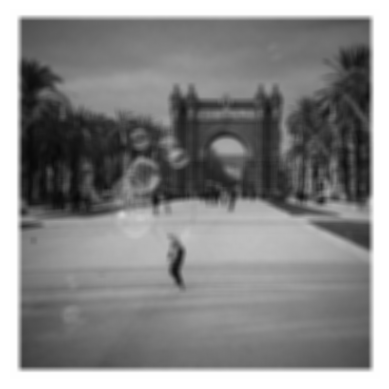

In [58]:
I = np.copy(img_out_quant)


k_size = (7,7)
kernel = np.ones((k_size[0], k_size[1]))

if I.dtype == np.uint8:
    img_copy = I.astype(np.float32) / 256
else:
    img_cope_nb = I
img_copy = cv.copyMakeBorder(img_copy, int (( k_size [0] - 1) / 2) , int ( k_size [0] / 2) , int (( k_size [1] - 1) / 2) ,
                           int ( k_size [1] / 2) , cv . BORDER_REPLICATE )

bgr_planes = cv.split(img_copy)
bgr_planes_2 = []
k_power = np.power(kernel,2)

for plane in bgr_planes:
    plane_power = np.power(plane,2)
    m = np.zeros(I.shape[0:2], np.float32)
    q = np.zeros(I.shape[0:2], np.float32)

    for i in range(k_size[0]):
        for j in range(k_size[1]):
            m = m + kernel[i,j] * plane[i:i + rows, j:j + cols]
            q = q + k_power[i,j] * plane_power[i:i + rows, j:j + cols]
    m = m / np.sum(kernel)
    q = q / np.sum(kernel)
    q = q - m * m

    v = np.sum(q)

    plane_2 = plane[(k_size[0]-1) // 2: (k_size[0]-1) // 2 + rows, (k_size[1] -1) // 2: (k_size[1] - 1) // 2 + cols]
    plane_2 = np.where(q < v, m, (plane_2 - m) * (1 - v / 1) + m)
    bgr_planes_2.append(plane_2)
I_out = cv.merge(bgr_planes_2)

plot_image(I_out)

Адаптивная медианная фильтрация 

In [86]:
def getResultFromMask(img,size_k):
    I = np.copy(img_out_pulse)
    
    k_size = (size_k,size_k)
    rank = int((size_k+1)/2 - 1)
    kernel = np.ones(k_size,dtype = np.float32)
    rows, cols = I.shape[0:2]
    
    if I.dtype == np.uint8:
        I_copy = I . astype ( np . float32 ) / 255
    else:
        I_copy = I
    I_copy = cv.copyMakeBorder(I_copy, int (( k_size [0] - 1) / 2) , int ( k_size [0] / 2) , int (( k_size [1] - 1) / 2) ,
                            int ( k_size [1] / 2) , cv . BORDER_REPLICATE )

    I_layers = np.zeros(I.shape + (k_size[0] * k_size[1], ), dtype = np.float32)

    if I.ndim == 2:
        for i in range(k_size[0]):
            for j in range(k_size[1]):
                I_layers[:,:, i * k_size[1] + j] = kernel[i,j] *  I_copy[i:i + rows, j:j + cols]
    else:
        for i in range(k_size[0]):
            for j in range(k_size[1]):
                I_layers[:,:,:, i * k_size[1] + j] = kernel[i, j] * I_copy[i:i + rows, j:j + cols, :]
    print(I_layers)
    return I_layers.sort()

In [87]:
I = img_out_pulse

s_size = 3
I_layer = getResultFromMask(I,s_size)
print(I_layer.shape)
s_max = 10

I_out = np.copy(I)
flag = True
while(flag):
    for x in range(0,I_layers.shape[0]):
        print(x)
        for y in range(0,I_layers.shape[1]):
            z_min = I_layers[x,y,0]
            z_med = I_layers[x,y,rank]
            z_max = I_layers[x,y,s_size ** 2 - 1]
            A_1 = z_med - z_min
            A_2 = z_med - z_max
            #print(np.all(A_1), ' ', np.all(A_2))
            #print(A_1, A_2)
            
            if A_1 > 0 and A_2 < 0:
                B_1 = I[x,y] - z_min
                B_2 = I[x,y] - z_max
                if B_1 > 0 and B_2 < 0:
                    I_out[x,y] = I[x,y]
                else:
                    I_out[x,y] = z_med
            else: 
                s_size+=1
                if s_size<=s_max:
                    I_layer = getResultFromMask(I,s_size)
                    tmp_flag = False
                    break
                else: 
                    I_out[x,y] = I[x,y]

    flag = False

      
plot_image(I)
plot_image(I_out) 

[[[1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  ...
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]]

 [[1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  ...
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]]

 [[1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  ...
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]]

 ...

 [[1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  ...
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]]

 [[1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  ...
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]]

 [[1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  ...
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]]]


AttributeError: 'NoneType' object has no attribute 'shape'